In [1]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analystcommunity.read_connection_data_warehouse import run_read_dwd_query
from analysts_tools.redash_methods import *

import random
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

# Cargue de Queries y parametros

In [2]:
def historic(card_id):    
    query = """
    WITH 
    gmv_month AS (
    SELECT DISTINCT
        s.identifier_value AS region_code,
        DATE_TRUNC('week', fs.order_submitted_date) AS week,
        dp.card_id,
        sum(fs.gmv_local) as gmv_week
    FROM dpr_sales.fact_sales                   fs
    INNER JOIN dpr_shared.dim_site              s   ON s.site_id = fs.dim_site
    INNER JOIN dpr_shared.dim_product           dp  ON dp.product_id = fs.dim_product

    WHERE 
        fs.gmv_enabled = TRUE
        AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
        AND fs.fb_order_status_id  IN (1,6,7,8)
        AND fs.is_deleted = FALSE
        AND fs.dim_status = 1
        AND dp.is_slot = 'false'
        AND fs.product_quantity_x_step_unit > 0
        AND DATE(fs.order_submitted_date) >= DATE_TRUNC('month', date(getdate()) - interval '12 month')
        AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
        AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
        AND dp.card_id = '{card_id}'

    GROUP BY 1,2,3
    ),

    almost AS (
    SELECT
        s.identifier_value AS region_code,
        DATE(fs.order_submitted_date) AS submit_date,
        --cat.parent_description as category,
        --cat.description AS subcategory,
        dp.card_id,
        dp.card_description AS product_name,
        --margin_mtd AS margin,
        cogs_p_day AS costo,
        --sum((fs.product_price * fs.product_quantity_x_step_unit)+fs.product_tax_iva) / nullif(sum(fs.product_quantity_x_step_unit),0) as product_price,
        --sum((fs.product_price_discount * fs.product_quantity_x_step_unit)+fs.product_tax_iva) / nullif(sum(fs.product_quantity_x_step_unit),0) as product_price_discount,
    --    sum(fs.gmv_local) as gmv,
    --    AVG(pb.price) AS benchmark,
        sum(fs.gmv_local)/gm.gmv_week as gmv_mix

    FROM dpr_sales.fact_sales                   fs
    INNER JOIN dpr_shared.dim_customer          dc  ON dc.customer_id = fs.dim_customer
    INNER JOIN dpr_shared.dim_site              s   ON s.site_id = fs.dim_site
    INNER JOIN dpr_shared.dim_product           dp  ON dp.product_id = fs.dim_product
    INNER JOIN dpr_shared.dim_category          cat ON cat.category_id = dp.category_id
    LEFT JOIN dpr_sales.fact_sales_discounts    fsd ON fs.order_item_id = fsd.order_item_id  
    INNER JOIN dpr_shared.dim_stock_unit        su  ON su.card_id = dp.card_id
    LEFT JOIN dpr_cross_business.fact_cross_business_insights cbi ON cbi.dim_stock_unit = su.stock_unit_id AND cbi.dim_date = fs.dim_submitted_date
    --INNER JOIN dpr_pricing.snap_daily_benchmark_competitor pb ON pb.dim_stock_unit = su.stock_unit_id AND fs.dim_submitted_date = pb.dim_benchmark_day
    INNER JOIN gmv_month                        gm  ON gm.card_id = dp.card_id AND gm.week = DATE_TRUNC('week', fs.order_submitted_date) AND gm.region_code = s.identifier_value
    WHERE 
        fs.gmv_enabled = TRUE
        AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
        AND fs.fb_order_status_id  IN (1,6,7,8)
        AND fs.is_deleted = FALSE
        AND fs.dim_status = 1
        AND dp.is_slot = 'false'
        AND fs.product_quantity_x_step_unit > 0
        AND DATE(fs.order_submitted_date) >= DATE_TRUNC('month', date(getdate()) - interval '12 month')
        AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
        AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
        AND margin_mtd IS NOT NULL
        AND dp.card_id = '{card_id}'

    GROUP BY 1,2,3,4,5,gm.gmv_week
    )

    SELECT 
    region_code,
    DATE_TRUNC('week', submit_date) AS week,
    card_id,
    product_name,
    --SUM(margin*gmv_mix) AS margin,
    SUM(costo*gmv_mix) AS costo
    --SUM(product_price*gmv_mix) AS product_price,
    --SUM(product_price_discount*gmv_mix) AS product_price_discount

    FROM almost
    GROUP BY 1,2,3,4
    """.format(card_id=card_id)
    df_cost = run_read_dwd_query(query)
    #df_cost['costo'] = pd.to_numeric(df_cost['costo'], errors='coerce')

    df_cost['costo'] = df_cost[['costo']].astype(float)
    
    
    df_cost = df_cost.loc[df_cost.costo > 0].sort_values(by=['region_code', 'card_id', 'week'])

    # Create a new column 'percentage_variation'
    df_cost['percentage_variation'] = 0.0

    # Group the data by 'region_code' and 'card_id'
    grouped = df_cost.groupby(['region_code', 'card_id'])

    df_cost['percentage_variation'] = grouped['costo'].pct_change() * 100


    # Reset the index of the DataFrame
    df_cost.reset_index(drop=True, inplace=True)
    
    return df_cost

In [3]:
def valores(card_id):
    query = """
    WITH MaxSubmitDates AS (
    SELECT
        dp.card_id,
        MAX(DATE(fs.order_submitted_date)) AS max_submit_date
    FROM dpr_sales.fact_sales fs
    INNER JOIN dpr_shared.dim_product dp ON dp.product_id = fs.dim_product
    INNER JOIN dpr_shared.dim_site s ON s.site_id = fs.dim_site
    INNER JOIN dpr_shared.dim_stock_unit su ON su.card_id = dp.card_id
    LEFT JOIN dpr_cross_business.fact_cross_business_insights cbi ON cbi.dim_stock_unit = su.stock_unit_id AND cbi.dim_date = fs.dim_submitted_date
    WHERE
        fs.gmv_enabled = TRUE
        AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED', 'No value')
        AND fs.fb_order_status_id IN (1, 6, 7, 8)
        AND fs.is_deleted = FALSE
        AND fs.dim_status = 1
        AND dp.is_slot = 'false'
        AND fs.product_quantity_x_step_unit > 0
        AND dp.card_id = {card_id}
        AND fs.order_submitted_date >= DATE_TRUNC('month', date(getdate()) - interval '2 month')
        AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
        AND EXTRACT(DOW FROM DATE(fs.order_submitted_date)) != 0 -- Exclude Sundays (DOW 0)
        AND cogs_p_day > 0
    GROUP BY dp.card_id
)

SELECT
    s.identifier_value AS region_code,
    DATE(fs.order_submitted_date) AS submit_date,
    dp.card_id,
    dp.card_description AS product_name,
    AVG(margin_mtd) AS margin,
    AVG(cogs_p_day) AS costo,
    sum((fs.product_price * fs.product_quantity_x_step_unit) + fs.product_tax_iva) / nullif(sum(fs.product_quantity_x_step_unit), 0) AS product_pricee,
    (sum(fs.product_tax_iva)/nullif(sum(fs.product_quantity_x_step_unit),0))/product_pricee AS tax
FROM dpr_sales.fact_sales fs
INNER JOIN dpr_shared.dim_customer dc ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site s ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product dp ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category cat ON cat.category_id = dp.category_id
LEFT JOIN dpr_sales.fact_sales_discounts fsd ON fs.order_item_id = fsd.order_item_id
INNER JOIN dpr_shared.dim_stock_unit su ON su.card_id = dp.card_id
LEFT JOIN dpr_cross_business.fact_cross_business_insights cbi ON cbi.dim_stock_unit = su.stock_unit_id AND cbi.dim_date = fs.dim_submitted_date
INNER JOIN MaxSubmitDates msd ON dp.card_id = msd.card_id AND DATE(fs.order_submitted_date) = msd.max_submit_date
WHERE
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED', 'No value')
    AND fs.fb_order_status_id IN (1, 6, 7, 8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.product_quantity_x_step_unit > 0
    AND dp.card_id = {card_id}
    AND fs.order_submitted_date >= DATE_TRUNC('month', date(getdate()) - interval '2 month')
    AND DATE(fs.order_submitted_date) < DATE_TRUNC('day', date(getdate()) - interval '0 day')
    AND EXTRACT(DOW FROM fs.order_submitted_date) != 0 -- Exclude Sundays (DOW 0)
    AND margin_mtd IS NOT NULL
GROUP BY 1, 2, 3, 4
""".format(card_id = card_id)
    df = run_read_dwd_query(query)
    df[['costo','margin','product_pricee','tax']] = df[['costo','margin','product_pricee','tax']].astype(float)
    return df.submit_date[0],df.costo[0],df.margin[0],df.tax[0],df.product_pricee[0]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

def plot_pairplot(card_id, percentile, margin_sug):
    # Filter the DataFrame for the specific card_id
    df_cost = historic(card_id)
    data = df_cost.loc[df_cost.card_id == card_id].percentage_variation.dropna()

    #Datos HOY
    fecha,costo,margin,tax,price = valores(card_id)
    print(f'fecha de ultimos valores: {fecha} // cost: {costo} // price: {price}')
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram on the left subplot with a customized color palette and more bins
    sns.histplot(data, ax=axes[0], bins=10, kde=True, color='blue', palette='coolwarm')
    axes[0].set_xlabel('Cost Variation (%)')
    axes[0].set_ylabel('Density')
    axes[0].set_title(f'Cost Variation Histogram for {df_cost.loc[df_cost.card_id == card_id].product_name.unique()[0]}')

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Create a range of values for the x-axis
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Plot the smooth line for the normal distribution on the right subplot
    axes[1].plot(x, p, 'k', linewidth=2, label='Fit results (Normal Distribution)')

    # Calculate the position at the specified percentile of the normal distribution
    percentile_position = np.percentile(data, percentile)
    
    # Plot a vertical line at that position on the right subplot
    axes[1].axvline(percentile_position, color='r', linestyle='--', label=f'{percentile}th Percentile')

    # Add a text annotation with the percentile value in red near the line
    axes[1].annotate(np.round(percentile_position, 2), xy=(percentile_position, 0.02), xytext=(percentile_position + 5, 0.03),
                     arrowprops=dict(facecolor='red', arrowstyle='->'), color='red', fontsize=12)

    # Add labels and legend on the right subplot
    axes[1].set_xlabel('Cost Variation (%)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Normal Distribution')
    axes[1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the pair plot
    plt.show()
    
    data = {
        'Percentil': [50,percentile],
        'Variation_Costo': [np.percentile(data, 50), percentile_position],
        'Costo': [costo*(1+np.percentile(data, 50)/100), costo*(1+percentile_position/100)],
        'Margin_Budget': [margin*100, margin_sug],
        'Precio': [costo*(1+np.percentile(data, 50)/100)*(1+margin)*(1+tax), costo*(1+percentile_position/100)*(1+margin_sug/100)*(1+tax)]
    }
    
    df = pd.DataFrame(data)
    print(df)

fecha de ultimos valores: 2023-09-26 // cost: 181015.0144 // price: 201095.6888


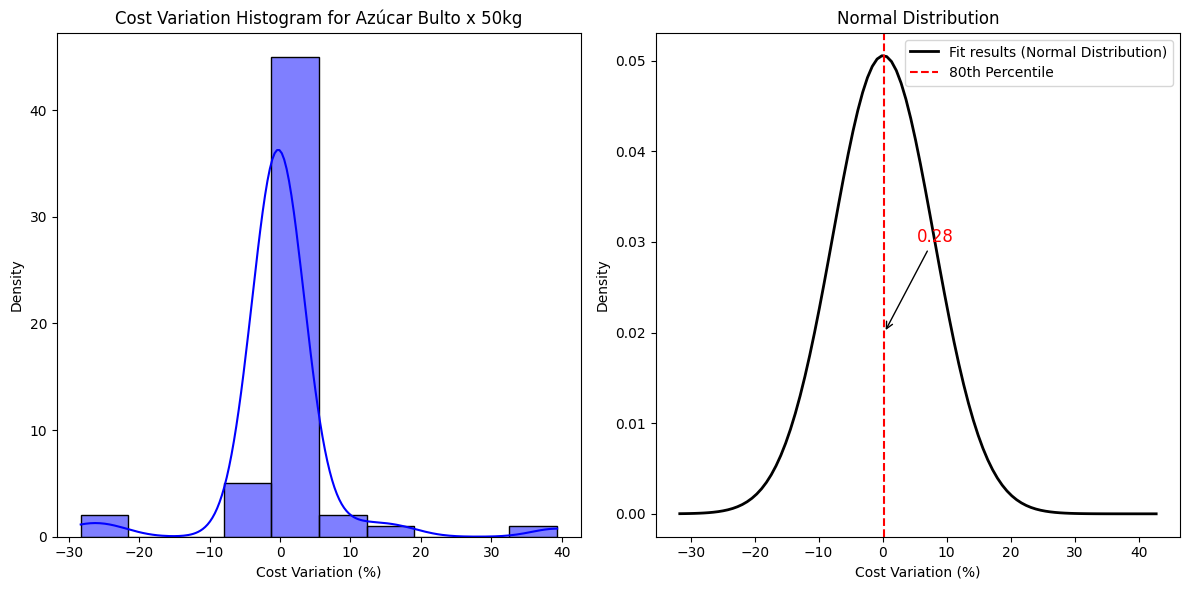

   Percentil  Variation_Costo          Costo  Margin_Budget         Precio
0         50        -0.163004  180719.953255           5.52  199334.209643
1         80         0.275568  181513.834640           3.00  195428.503690


In [9]:
card_id = -200916
percentil = 80
margin_sug = 3

plot_pairplot(card_id, percentil, margin_sug)